# Example of using nessai

This notebooks shows an example of using `nessai` for Bayesian inference.

For more details about nessai see: https://nessai.readthedocs.io/ and [Nested Sampling with Normalising Flows for Gravitational-Wave Inference](https://arxiv.org/abs/2102.11056).

If you want to try this example locally `nessai` can be installed using `pip`:

```python
pip install nessai
```

In [1]:
import numpy as np
from scipy.stats import norm

from nessai.flowsampler import FlowSampler
from nessai.model import Model
from nessai.plot import plot_live_points
from nessai.utils import setup_logger

We're going set up a logger to log the output from `nessai`, this is based on the implementation in `bilby`.

See: https://git.ligo.org/lscsoft/bilby

In [2]:
output = './output/'
logger = setup_logger(output=output)

## Defining the model
 
In this case we're using a simple 2-dimensionl Gaussian since it will run relatively quickly. 

The model must contain names for each of the parameters and their prior bounds as a dictionary with arrays/lists with the mininimum and maximum.

The main functions in the model should be the `log_prior` and `log_likelihood`. 

The log prior must be able to accept structed arrays of points where each field is one of the names in the model and there are two extra fields which are `logP` and `logL`. The log-likelihood should accept the same inputs as the prior and return the log-likelihood of the given point.

In [3]:
class GaussianModel(Model):
    """
    A simple two-dimensional Guassian likelihood
    """
    def __init__(self):
        # Names of parameters to sample
        self.names = ['x0', 'x1']
        # Prior bounds for each parameter
        self.bounds = {n: [-10, 10] for n in self.names}

    def log_prior(self, x):
        """
        Returns log of prior given a live point assuming uniforn
        priors on each parameter.
        
        Should also checks if the points are within the prior bounds.
        """
        # Check the values are within the prior bounds.
        # Since we use the log prior we take the log of outputs
        # This will return 0 if the point is in bounds and -inf if it
        # is outside the bounds.
        log_p = np.log(self.in_bounds(x))
        # Iterate through each parameter (x and y)
        # Since the live points are a structured array we can
        # get each value using just the name
        for n in self.names:
            log_p -= (np.log(self.bounds[n][1] - self.bounds[n][0]))
        return log_p

    def log_likelihood(self, x):
        """
        Returns log likelihood of given live point assuming a Gaussian
        likelihood.
        """
        log_l = np.zeros(x.size)
        # Use a Guassian logpdf and iterate through the parameters
        for n in self.names:
            log_l += norm.logpdf(x[n])
        return log_l

## Configuring `nessai`

There are two aspects to configure in `nessai`: the normalising flow and the actual sampler.

### Configuring the normalisng flow

The normalsing flow that is trained to produce the proposal points is configured with a dictionary that contains the parameters related to training (e.g. learning rate (lr) or batch size) and `model_config` for the configuring
the flow itself (neurons, number of trasformations, etc.). 

This is only necessary for particularly complex likelihoods. In this example we include it to demonstrate how it can be done.

In [4]:
flow_config = dict(
    batch_size=1000,   # Use a batchsize of 1000
    model_config=dict(
        n_blocks=2,    # Use two transforms
        n_layers=2,    # Use 1 layer in the NN in each transform
        n_neurons=4,   # Use 4 neurons per layer
    )
)


### Configuring the samper

The `FlowSampler` object is used to managed the sampling settings, run and resume the sampler.

In [5]:
fs = FlowSampler(
    GaussianModel(),           # The model
    output=output,             # Output directory
    nlive=2000,                # Number of live points
    flow_config=flow_config,   # Configuration for the flow
    resume=False,              # Don't resume the previous run
    seed=170817                  # Set a random seed, this also seeds `torch`
)

12-10 11:19 nessai.nestedsampler WARNING : Proposal will only train when empty


Then run the sampler.

Whilst running the sampler will print statistics that describe it's current state. We normally focus on `dZ` since by default the sampler will stop when `dZ<=0.1`.

Also, notice how p-values are periodically printed. This is an indication of whether the insertion indices are uniformly distributed.

In [6]:
fs.run()

Drawing live points: 100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 6088.96it/s]
12-10 11:19 nessai.nestedsampler CRITICAL: Starting nested sampling loop
12-10 11:19 nessai.nestedsampler WARNING : it:  2000: n eval: 5473 H: 3.15 dZ: 26.479 logZ: -29.321 +/- 0.040 logLmax: -1.84
12-10 11:19 nessai.nestedsampler CRITICAL: Checkpointing nested sampling
12-10 11:19 nessai.nestedsampler WARNING : Rolling KS test: D=0.021, p-value=0.169
12-10 11:19 nessai.nestedsampler WARNING : it:  4000: n eval: 14926 H: 3.17 dZ: 10.772 logZ: -14.615 +/- 0.040 logLmax: -1.84
12-10 11:19 nessai.nestedsampler CRITICAL: Checkpointing nested sampling
12-10 11:19 nessai.nestedsampler WARNING : Rolling KS test: D=0.0035, p-value=0.95
12-10 11:19 nessai.nestedsampler WARNING : Switching to FlowProposal
12-10 11:19 nessai.nestedsampler WARNING : it:  6000: n eval: 19814 H: 3.14 dZ: 4.301 logZ: -9.130 +/- 0.040 logLmax: -1.84
12-10 11:19 nessai.nestedsampl

By default the sampler stops once `dZ<=0.1` and returns the finale evidence and other summary statistics.

## Results

The results will be saved to the output directory, but we can examine some of them here.

## Evidence

The log-evidence can be retrieved from the sampler along with log-evidence error.

In [7]:
print(f'Final log-evidence: {fs.logZ}')

Final log-evidence: -5.96874162864521


### Posterior samples

We can plot the posterior samples

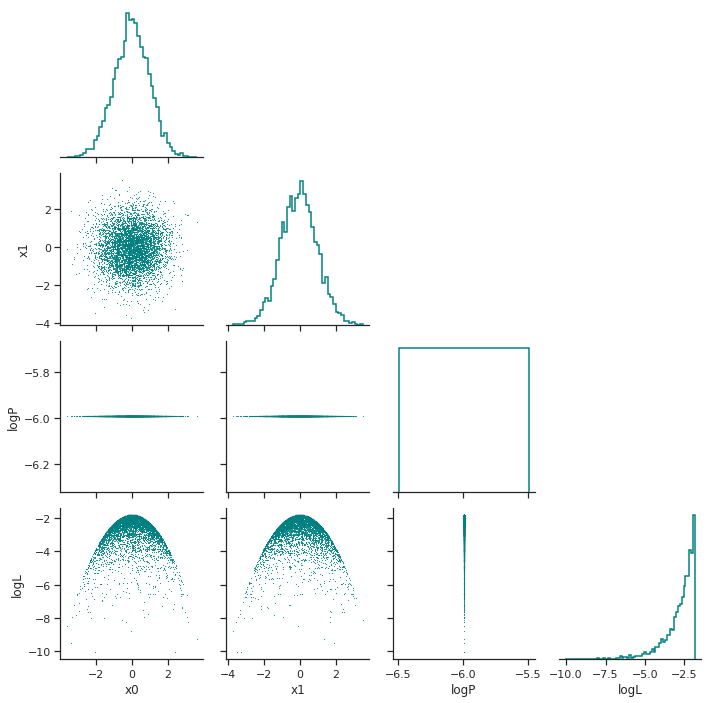

In [8]:
fig = plot_live_points(fs.posterior_samples)

## Diagnostic plots

The instance of `FlowSampler` contains the actual nested sampler that has some useful methods that we can use to produce some diagnostic plots

### Trace plot

A trace plot is standard way to examine how the sampler explored the parameter space.

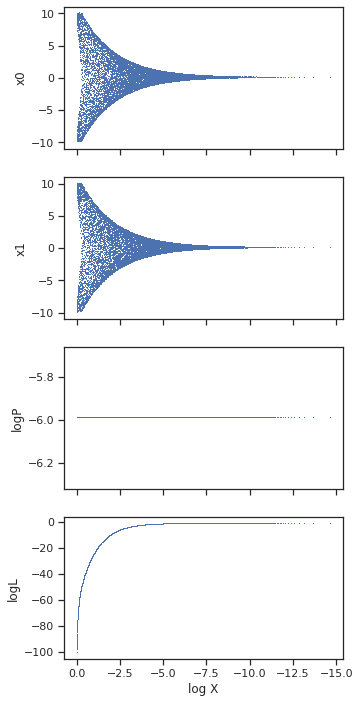

In [9]:
fig = fs.ns.plot_trace()

### State plot

This plot shows us the evolution of the sampler by interation, including when the sampler trained the normalising flow (vertical lines), number of likelihood evaluations and the proposal acceptance.

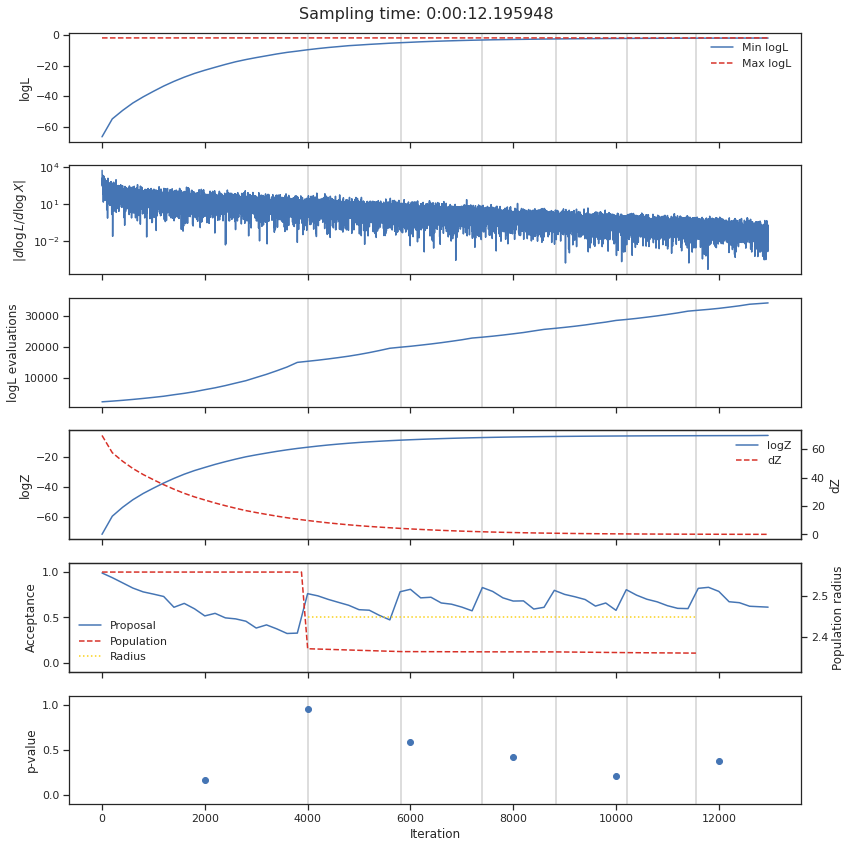

In [10]:
fig = fs.ns.plot_state()

### Insertion indices

We can also check the insertion indices, they should be approximatly uniform. For details about why this is, see: [Nested sampling cross-checks using order statistics](https://arxiv.org/abs/2006.03371)/

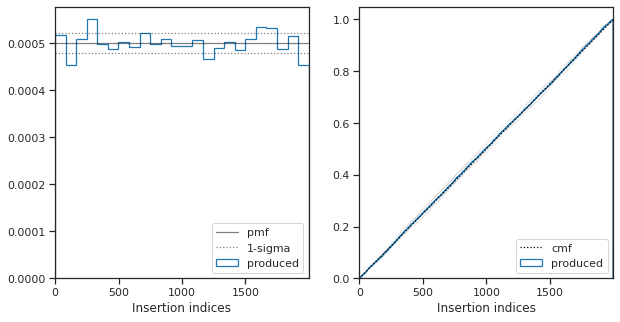

In [11]:
fig = fs.ns.plot_insertion_indices()